<a href="https://colab.research.google.com/github/mori01-22/kennkyu/blob/main/Sample1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# タンス検出 (二値分類) ノートブック

このノートブックは、与えられた画像（タンスあり / タンスなし）を識別するための学習・評価・推論パイプラインを示します。主に TensorFlow / Keras の転移学習（MobileNetV2）を利用します。

前提: 画像データはローカルに用意され、以下のようなフォルダ構成になっていることを想定します:

```
data/
  train/
    tansu/        # タンスが写っている画像（約1000枚程度）
    not_tansu/    # タンスが写っていない画像
```

(検証は自動で分割します)

ノート: このノートブックは Colab / ローカルどちらでも動きます。ローカル環境で GPU を使う場合は適切に TensorFlow をインストールしてください。

In [1]:
# 基本的なインポートと設定
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)

# 再現性のためのシード設定（任意）
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)

TensorFlow version: 2.20.0


In [2]:
# データセットのパスとパラメータ（必要に応じて変更）
data_dir = Path('data/train')  # ここに tansu と not_tansu のフォルダがある想定
img_size = (224, 224)
batch_size = 32

# ヘルパ: デモ用の簡易画像データを生成（data/demo_train に作成）
def create_demo_data(base_dir, img_size=(224,224), n_per_class=12):
    from PIL import Image, ImageDraw
    base = Path(base_dir)
    (base / 'tansu').mkdir(parents=True, exist_ok=True)
    (base / 'not_tansu').mkdir(parents=True, exist_ok=True)
    w, h = img_size
    for i in range(n_per_class):
        # タンスっぽい四角を描いた画像
        img = Image.new('RGB', (w, h), color=(150, 120, 90))
        d = ImageDraw.Draw(img)
        d.rectangle([int(w*0.2), int(h*0.2), int(w*0.8), int(h*0.9)], fill=(80, 60, 40))
        img.save(base / 'tansu' / f'tansu_{i}.jpg', 'JPEG')
        # タンスなし（丸）画像
        img2 = Image.new('RGB', (w, h), color=(200, 220, 240))
        d2 = ImageDraw.Draw(img2)
        d2.ellipse([int(w*0.3), int(h*0.3), int(w*0.7), int(h*0.7)], fill=(120, 140, 160))
        img2.save(base / 'not_tansu' / f'not_{i}.jpg', 'JPEG')
    print(f'Created demo dataset at: {base.resolve()} (each class: {n_per_class} images)')

# フォルダ存在確認・デモ作成（不足時）
if not data_dir.exists() or not any(p.is_dir() for p in data_dir.iterdir()):
    print('警告: data/train が見つからない、またはクラスフォルダが不足しています。デモ用データを生成します。')
    demo_dir = Path('data/demo_train')
    if not demo_dir.exists() or not any(p.is_dir() for p in demo_dir.iterdir()):
        create_demo_data(demo_dir, img_size=img_size, n_per_class=12)
    data_dir = demo_dir

# クラスフォルダ数の確認（label_mode='binary' の場合は 2 クラス必須）
subdirs = [p.name for p in data_dir.iterdir() if p.is_dir()]
print('Found class folders:', subdirs)
if len(subdirs) < 2:
    raise ValueError(f'二値分類には少なくとも2つのクラスフォルダが必要です。見つかったクラス: {subdirs}')

# データ読み込み (80% training, 20% validation) - TensorFlow のユーティリティを使用
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print('Classes:', class_names)


警告: data/train が見つからない、またはクラスフォルダが不足しています。デモ用データを生成します。
Found class folders: ['not_tansu', 'tansu']
Found 24 files belonging to 2 classes.
Using 20 files for training.
Using 20 files for training.
Found 24 files belonging to 2 classes.
Using 4 files for validation.
Classes: ['not_tansu', 'tansu']
Found 24 files belonging to 2 classes.
Using 4 files for validation.
Classes: ['not_tansu', 'tansu']


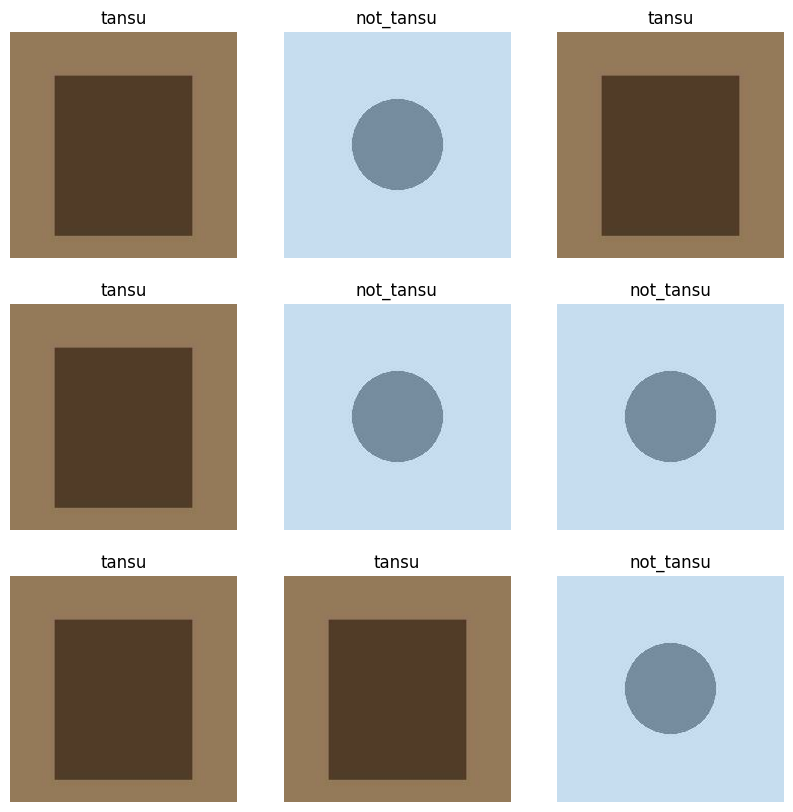

In [ ]:
# パフォーマンス最適化: キャッシュとプリフェッチ
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
# データ拡張レイヤー（学習時のみ適用）
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name='data_augmentation')

# 正規化レイヤー (MobileNetV2 では入力を [-1,1] にスケーリングするのが一般的)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [5]:
# モデル構築: 転移学習(MobileNetV2) + 軽いヘッド
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet')
base_model.trainable = False  # まずは凍結してヘッドのみ学習

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

OSError: Unable to synchronously open file (truncated file: eof = 5152768, sblock->base_addr = 0, stored_eof = 9406464)

In [ ]:
# コールバック: 早期終了とモデル保存
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_tansu_model.h5', save_best_only=True)
]

# 学習（ヘッドのみ）
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

In [ ]:
# モデル保存 — Keras ネイティブ形式（推奨）と SavedModel（TFLite/TF Serving 用）を両方試す
try:
    # Keras ネイティブ形式（単一ファイル）
    model.save('tansu_detector.keras')
    print('モデルを tansu_detector.keras に保存しました (Keras native format)')
except Exception as e:
    print('Keras native save failed:', e)
